In [1]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
import os

In [2]:
# class LJ8_3(nn.Module):
#     """Feedfoward neural network with 2 hidden layer"""
#     def __init__(self, in_size, hidden_size,hidden_size2, out_size):
#         super().__init__()
#         # 1st hidden layer
#         self.linear1 = nn.Linear(in_size, hidden_size)
#         # 2nd hidden layer
#         self.linear2 = nn.Linear(hidden_size,hidden_size2)
#         # output layer
#         self.linear3 = nn.Linear(hidden_size2, out_size)
        
#     def forward(self, xb):
#         # Get information from the data
#         # Get intermediate outputs using hidden layer
#         out = self.linear1(xb)
#         # Apply activation function
#         tanhf = nn.ReLU()
#         out = tanhf(out)
#         # Get predictions using output layer
#         out = self.linear2(out)
#         # apply activation function again
#         out = tanhf(out)
#         # last hidden layer 
#         out = self.linear3(out)
#         #sigmoid function
#         out = torch.sigmoid(out)
#         return out
    

In [3]:
class LJ8_3(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size,hidden_size2, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # 2nd hidden layer
        self.linear2 = nn.Linear(hidden_size,hidden_size2)
        self.linear3 = nn.Linear(hidden_size2,hidden_size2)
        # output layer
        self.linear4 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Get information from the data
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        tanhf = nn.ReLU()
        out = tanhf(out)
        # Get predictions using output layer
        out = self.linear2(out)
        # apply activation function again
        out = tanhf(out)
        # last hidden layer 
        out = self.linear3(out)
        
        out = tanhf(out)
        # last hidden layer 
        out = self.linear4(out)
        
        #sigmoid function
        out = torch.sigmoid(out)
        return out

In [4]:
beta = 20
fname = "Data/Committor_mu2mu3_BETA"+str(beta) + '.npz'
inData = np.load(fname)
pts = inData["points"]
Q = inData["committor"]
tri = inData['tri']
CVlist = inData['CVlist']
print(f"Shape of trajectory data:{pts.shape}")
train_data = torch.tensor(pts,dtype=torch.float32)
Q = torch.tensor(Q,dtype=torch.float32)

ptsA = torch.tensor(np.loadtxt("FEMdataBETA" + str(beta) +"/ptsA.csv", delimiter=','), dtype=torch.float32)
ptsB = torch.tensor(np.loadtxt("FEMdataBETA" + str(beta) +"/ptsB.csv", delimiter=','), dtype=torch.float32)

train_data = torch.cat((train_data, ptsA, ptsB), 0)
Q= torch.cat((Q, torch.zeros(len(ptsA)), torch.ones(len(ptsB))), 0)
train_data.requires_grad_(True)

print(train_data.shape, Q.shape)

# initialization
input_size = 2
output_size = 1
model = LJ8_3(input_size,25,25,output_size)

train_ds = TensorDataset(train_data,Q)
batch_size = 512
print(f"batch size:{batch_size}")
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,150,200,300,400], gamma=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)


Shape of trajectory data:(4753, 2)
torch.Size([5182, 2]) torch.Size([5182])
batch size:512


In [5]:
# save_folder = "Data/Committor_mu2mu3_BETA"+str(beta)
# for name, param in model.named_parameters():
#     shape_str = ",".join(map(str, param.shape))
#     filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")

#     if os.path.exists(filename):
#         param_data = np.loadtxt(filename, delimiter=",")  # Load CSV data
#         param_data = torch.tensor(param_data, dtype=param.dtype)  # Convert to tensor

#         # **Fix shape mismatches**
#         if param.shape != param_data.shape:
#             if len(param.shape) == 2 and len(param_data.shape) == 1:
#                 param_data = param_data.view(param.shape)  # Reshape 1D -> 2D
#             elif len(param.shape) == 1 and param_data.numel() == 1:
#                 param_data = param_data.view(1)  # Reshape scalar -> (1,)
#             else:
#                 print(f"Skipping {name} due to incompatible shape {param_data.shape}")

#         # Load into model if shape matches
#         if param.shape == param_data.shape:
#             param.data.copy_(param_data)
#             print(f"Loaded: {filename}")
#         else:
#             print(f"Shape mismatch for {name}: expected {param.shape}, got {param_data.shape}")
#     else:
#         print(f"File not found: {filename}")

# # Set model to evaluation mode
# model.eval()


In [6]:
for epoch in range(1000):
    for X,y in train_dl:
        optimizer.zero_grad()

        Q_nn = model(X)

        loss = loss_fn(Q_nn.squeeze(), y)
        loss.backward()
        optimizer.step()
    scheduler.step()

    if epoch%25 == 0:
        print('Epoch: {}, Loss : {:.4f}'.format(epoch, loss))

Epoch: 0, Loss : 0.1890
Epoch: 25, Loss : 0.0040
Epoch: 50, Loss : 0.0044
Epoch: 75, Loss : 0.0008
Epoch: 100, Loss : 0.0011
Epoch: 125, Loss : 0.0004
Epoch: 150, Loss : 0.0020
Epoch: 175, Loss : 0.0009
Epoch: 200, Loss : 0.0008
Epoch: 225, Loss : 0.0006
Epoch: 250, Loss : 0.0003
Epoch: 275, Loss : 0.0015
Epoch: 300, Loss : 0.0010
Epoch: 325, Loss : 0.0008
Epoch: 350, Loss : 0.0004
Epoch: 375, Loss : 0.0009
Epoch: 400, Loss : 0.0008
Epoch: 425, Loss : 0.0005
Epoch: 450, Loss : 0.0006
Epoch: 475, Loss : 0.0005
Epoch: 500, Loss : 0.0005
Epoch: 525, Loss : 0.0002
Epoch: 550, Loss : 0.0002
Epoch: 575, Loss : 0.0004
Epoch: 600, Loss : 0.0002
Epoch: 625, Loss : 0.0003
Epoch: 650, Loss : 0.0003
Epoch: 675, Loss : 0.0001
Epoch: 700, Loss : 0.0002
Epoch: 725, Loss : 0.0002
Epoch: 750, Loss : 0.0002
Epoch: 775, Loss : 0.0002
Epoch: 800, Loss : 0.0002
Epoch: 825, Loss : 0.0002
Epoch: 850, Loss : 0.0003
Epoch: 875, Loss : 0.0003
Epoch: 900, Loss : 0.0002
Epoch: 925, Loss : 0.0001
Epoch: 950, Loss 

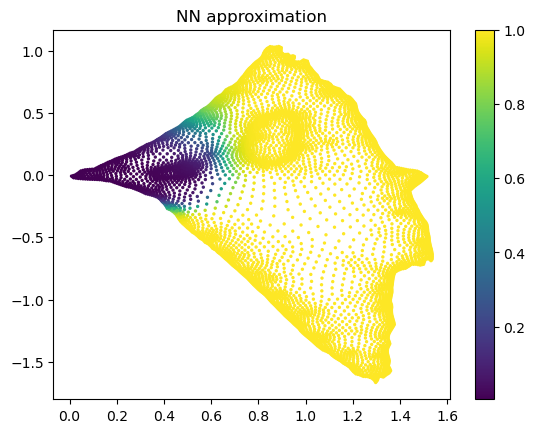

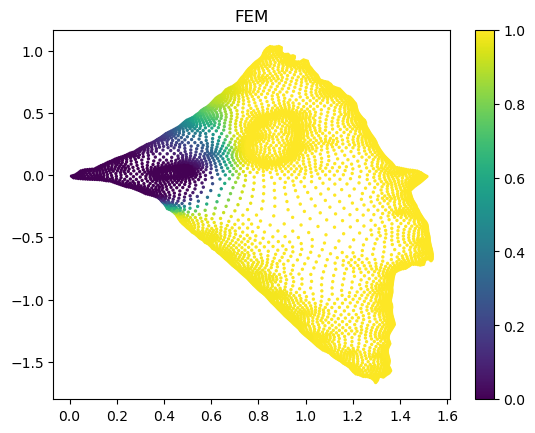

In [7]:
# comparison
Q = inData["committor"]
Q = torch.tensor(Q,dtype=torch.float32)
Q= torch.cat((Q, torch.zeros(len(ptsA)), torch.ones(len(ptsB))), 0)
q_model = model(train_data)
plt.figure()
plt.scatter(train_data[:,0].detach(), train_data[:,1].detach(), s = 2, c = q_model.detach().numpy())
plt.title("NN approximation")
plt.colorbar()

plt.figure()
plt.scatter(train_data[:,0].detach(), train_data[:,1].detach(), s = 2, c = Q.detach().numpy())
plt.title("FEM")
plt.colorbar()



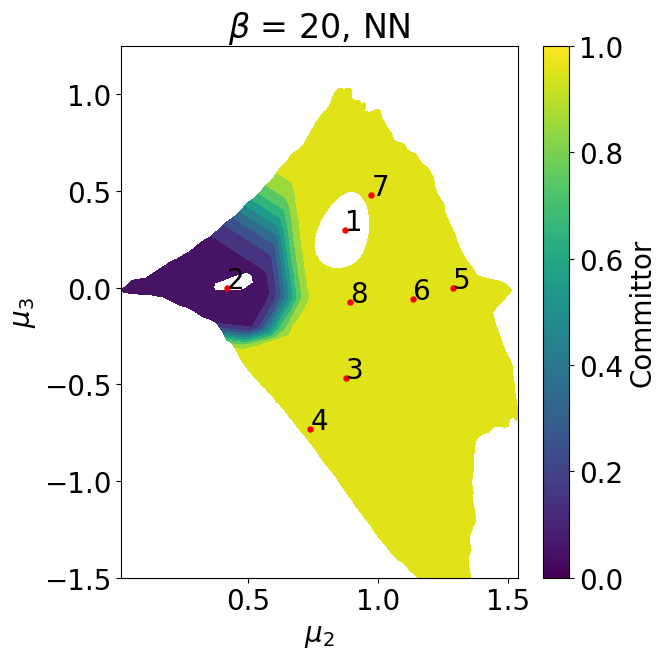

In [13]:
q = model(torch.tensor(pts, dtype = torch.float32))
plt.figure(figsize=(7,7))    
plt.rcParams.update({'font.size': 20})
plt.tricontourf(pts[:,0], pts[:,1],tri,q[:,0].detach(),np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1+1e-4]))
plt.scatter(CVlist[:,0],CVlist[:,1],s = 13, c = 'red')
for j in range(8):
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'black')
plt.colorbar(label="Committor", orientation="vertical")
plt.xlabel(r"$\mu_2$")
plt.ylabel(r"$\mu_3$")
# axes=plt.gca()
# axes.set_aspect(1)
plt.title(r'$\beta$' + ' = ' + str(beta) + ', NN')
plt.ylim([-1.5, 1.25])
plt.tight_layout()

fname = "Figures/NN_Committor_mu2mu3_BETA"+str(beta)+".pdf"
plt.savefig(fname)

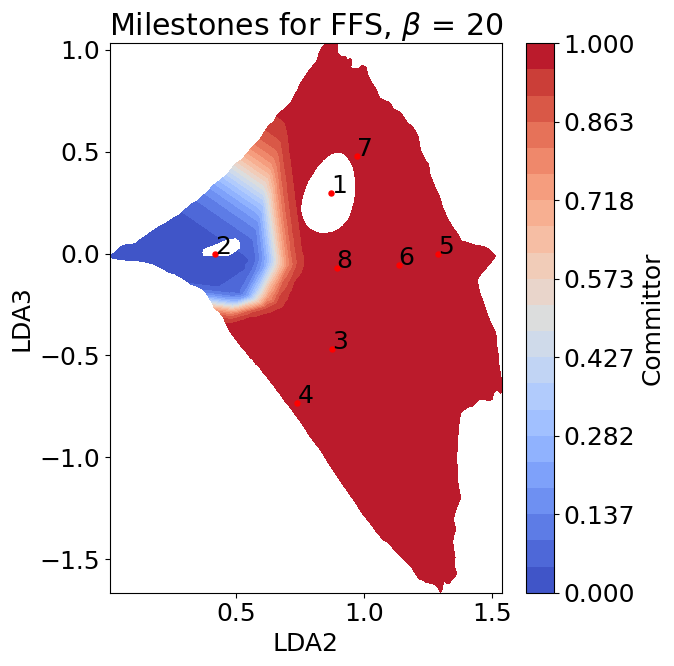

In [11]:
q = model(torch.tensor(pts, dtype = torch.float32))
plt.figure(figsize=(7,7))    
plt.rcParams.update({'font.size': 18})
levels = 0.1*np.array([0., 0.4, 0.88, 1.37, 1.85, 2.34, 2.82, 3.31, 3.79, 4.27, 4.76, 5.24, 5.73, 6.21, 6.69, 7.18, 7.66, 8.15, 8.63, 9.12, 9.6, 10.+1e-4])
plt.tricontourf(pts[:,0], pts[:,1],tri,q[:,0].detach(),levels, cmap = 'coolwarm')
plt.colorbar(label="Committor", orientation="vertical")
plt.scatter(CVlist[:,0],CVlist[:,1],s = 13, c = 'red')
for j in range(8):
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'black')
plt.xlabel("LDA2")
plt.ylabel("LDA3")
# axes=plt.gca()
# axes.set_aspect(1)
plt.title(r'Milestones for FFS, $\beta$' + ' = ' + str(beta))
plt.tight_layout()

fname = "Figures/NN_Committor_levels_mu2mu3_BETA"+str(beta)+".pdf"
plt.savefig(fname)


In [10]:
save_folder = "Data/Committor_mu2mu3_BETA"+str(beta)
os.makedirs(save_folder, exist_ok=True)  # Create folder if not exists

# Loop through each named parameter in the model
for name, param in model.named_parameters():
    shape_str = ",".join(map(str, param.shape))  # Convert shape tuple to string (e.g., "10x5")
    filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")  # Include shape in filename
    np.savetxt(filename, param.detach().cpu().numpy(), delimiter=',')  # Save as .npy
    print(f"Saved: {filename}")

Saved: Data/Committor_mu2mu3_BETA20/linear1_weight_[25,2].csv
Saved: Data/Committor_mu2mu3_BETA20/linear1_bias_[25].csv
Saved: Data/Committor_mu2mu3_BETA20/linear2_weight_[25,25].csv
Saved: Data/Committor_mu2mu3_BETA20/linear2_bias_[25].csv
Saved: Data/Committor_mu2mu3_BETA20/linear3_weight_[25,25].csv
Saved: Data/Committor_mu2mu3_BETA20/linear3_bias_[25].csv
Saved: Data/Committor_mu2mu3_BETA20/linear4_weight_[1,25].csv
Saved: Data/Committor_mu2mu3_BETA20/linear4_bias_[1].csv
